In [80]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import random

In [39]:
# Load data
train_features = np.load('data/train_D-1.npy', allow_pickle=True)
train_labels = np.load('data/train_gs-1.npy', allow_pickle=True)
test_features = np.load('data/test_D-1.npy', allow_pickle=True)
test_labels = np.load('data/test_gs-1.npy', allow_pickle=True)

In [34]:
print('num images: ' + str(train_features.shape[0]))
print('num sift features: ' + str(train_features[0].shape[0]))

num images: 1888
num sift features: 203


In [31]:
# what k seems reasonable? elbow test

ks = range(10, 200, 10)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(train_features)
    print('sum of squared distance: ' + str(kmeans.inertia_/(len(train_features)*203))) # inertia divided by the number of features for each image

sum of squared distance: 529.4700527584596
sum of squared distance: 486.9992236506184
sum of squared distance: 463.66755310562775
sum of squared distance: 447.7260428924512
sum of squared distance: 436.8359076786965
sum of squared distance: 428.08095003869363
sum of squared distance: 421.08919119199936
sum of squared distance: 415.034879003167
sum of squared distance: 409.6520969667171
sum of squared distance: 405.00871202530016
sum of squared distance: 400.920308398229
sum of squared distance: 397.54649287046334
sum of squared distance: 394.1114758006229
sum of squared distance: 391.07611851023165
sum of squared distance: 388.2357001515853
sum of squared distance: 385.7414596031042
sum of squared distance: 383.3959307197375
sum of squared distance: 381.1007940219557
sum of squared distance: 378.9872111466336


### **K Means Clustering Algorithm**

To first cluster the data, we need to stack all of the SIFT features into one array. To optimize for performance and runtime, I'm going to partition 1/4ths of the training data to first determine an optimal k number of clusters using the elbow method to see at which point, increasing clusters does not result in a substantial increase in differentiation between clusters. From there, we will experiment with different stopping criteria to optimize runtime and cluster quality.

In [50]:
# Partition the SIFT features in train_features
train, _ = train_test_split(train_features, test_size=0.80, random_state=42)
all_features = np.vstack(train)

# Check shape
all_features.shape

(84191, 128)

Text(0.5, 1.0, 'Elbow Method For Optimal k')

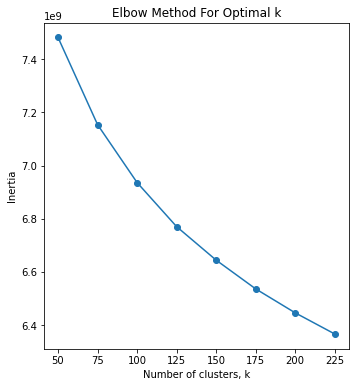

In [51]:
k_values = range(50, 250, 25)

inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(all_features)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_

# Plotting the results
# Inertia plot (Elbow Method)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')

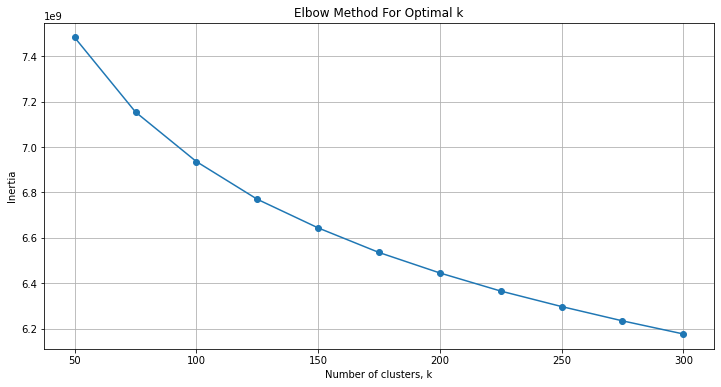

In [53]:
new_k_values = [250, 275, 300]

k_values = list(k_values)
k_values.extend(new_k_values)

for k in new_k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(all_features)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

After fitting to 20% of the training dataset, using the elbow method, we are able to see a decrease in the rate of change in inertia as we approach a cluster size of 300. This implies that once approaching this many clusters, the difference in means square loss between features put into the cluster doesn't change too much. We'll extrapolate this data, and use a k size of 250, for 250 visual words in our dictionary.

Next, we'll add in tolerance and max iter parameters to see if there's an impact on inertia while using the same cluster size.

In [54]:
max_iters = [100, 200, 300]

for iter in max_iters:
    kmeans = KMeans(n_clusters=250, random_state=0, tol=1e-4, max_iter=iter)
    kmeans.fit(all_features)
    print("Inertia: ", str(kmeans.inertia_))

# Negligible difference in inertia implies that there isn't difficulty in convergence.

Inertia:  6298051141.464458
Inertia:  6297996496.967546
Inertia:  6297996496.967546


In [56]:
# Now with full training dataset
full_train = np.vstack(train_features)
kmeans = KMeans(n_clusters=250, random_state=0, tol=1e-4, max_iter=100)
kmeans.fit(full_train)

KMeans(max_iter=100, n_clusters=250, random_state=0)

In [57]:
kmeans2 = kmeans

### **Visual Bag of Words Histogram**

First we'll create histograms by iterating through all of the SIFT features, then visualize the clusters as bins. Next we'll visualize a sample image and its respective histogram.

In [70]:
# Create the histograms for each image from the original feature training set

visual_words_histograms = []
label_to_feature_visualized_dict = {}

for features in train_features:
    labels = kmeans.predict(features)   # Assign each SIFT feature to a cluster
    histogram, bin_edges = np.histogram(labels, bins=np.arange(251))
    visual_words_histograms.append(histogram)

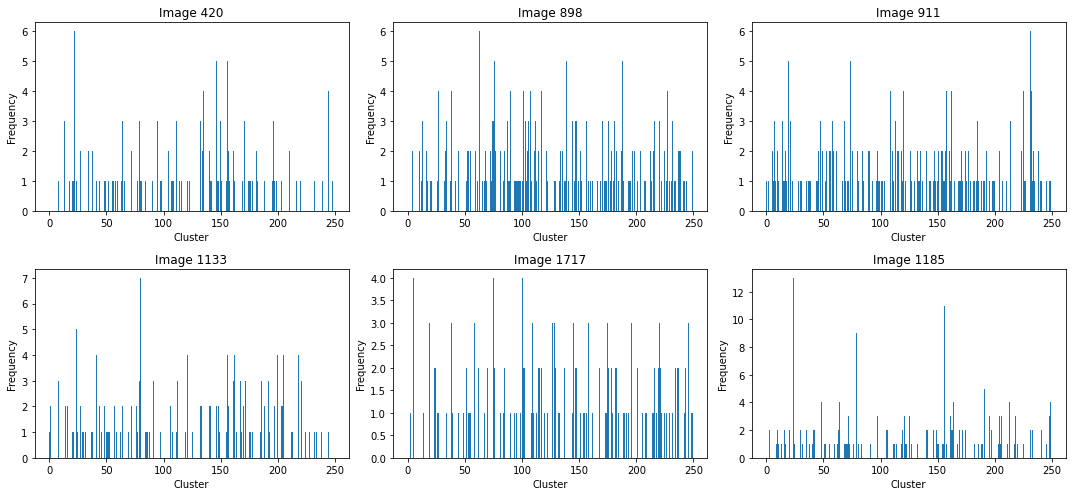

In [72]:
import numpy as np
import matplotlib.pyplot as plt

visual_words_histograms = []
label_to_feature_visualized_dict = {}

for features in train_features:
    labels = kmeans.predict(features)   # Assign each SIFT feature to a cluster
    histogram, _ = np.histogram(labels, bins=np.arange(250+1))
    visual_words_histograms.append(histogram)

num_samples = 6
sample_indices = np.random.choice(len(train_features-1), size=num_samples, replace=False)

plt.figure(figsize=(15, 7))
for i, index in enumerate(sample_indices, 1):
    plt.subplot(2, num_samples//2, i)
    plt.bar(range(250), visual_words_histograms[index])
    plt.title(f'Image {index}')
    plt.xlabel('Cluster')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### **KNN Classifier**

First create histograms using the cluster predictions for the data in the test set. Then we'll use KNN to match

In [ ]:
test_histograms = []
for features in test_features:
    labels = kmeans.predict(features)
    histogram, _ = np.histogram(labels, bins=np.arange(251))
    test_histograms.append(histogram)

train_labels = train_labels.flatten()
test_labels = test_labels.flatten()

knn = KNeighborsClassifier(n_neighbors=18)
knn.fit(visual_words_histograms, train_labels)

# Classify the test images
test_predictions = knn.predict(test_histograms)

In [121]:
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)
print()

accuracy = accuracy_score(test_labels, test_predictions)
print("Overall categorization accuracy: {:.2f}%".format(accuracy * 100))
print()

print("Detailed classification report:")
print(classification_report(test_labels, test_predictions))

Confusion Matrix:
[[74  1 11  0  5  6  0  3]
 [ 1 95  0  0  2  1  1  0]
 [37  3 40  1  4  6  4  5]
 [ 7 13  2 57  1  5  3 12]
 [10 16  2  0 48 14  1  9]
 [42  6  3  0 12 33  0  4]
 [ 3 13  8  7  8 12 31 18]
 [11  5  7 11  4  9  2 51]]

Overall categorization accuracy: 53.62%

Detailed classification report:
              precision    recall  f1-score   support

           1       0.40      0.74      0.52       100
           2       0.62      0.95      0.75       100
           3       0.55      0.40      0.46       100
           4       0.75      0.57      0.65       100
           5       0.57      0.48      0.52       100
           6       0.38      0.33      0.35       100
           7       0.74      0.31      0.44       100
           8       0.50      0.51      0.50       100

    accuracy                           0.54       800
   macro avg       0.56      0.54      0.53       800
weighted avg       0.56      0.54      0.53       800



### **Design Decisions**

#### K-Means

As discussed above, the number of visual words, or the number of clusters, was determined by partitioning 20% of the data, and performing an elbow test to determine an appropriate amount of clusters. In this case, we wanted to optimize runtime on a larger dataset, so we tracked inertia to see at what point adding clusters would not make groupings more consistent. As shown in the graphs above, I decided on k = 250.

#### Stopping Criterion

To avoid convergence difficulties in determining K Means clusters, I set up some default stopping criterion. These parameters were tolerace of 1e-4 and a maximum iterations of 100. From there, I noticed not much change in inertia testing different values for these params, so I settled on a lower tolerance and max iters to optimize runtime, indicating that the algorithm did not have much difficulty converging.

#### Binning Parameters
Binning directly corresponded to the labels. This was done to match histograms accordingly. Since we had 250 clusters, and not all images had all clusters, this worked in our favor as more alike images would feature more of the same clusters, or bins.

#### K for KNN
KNN ran really fast, so guess and check worked here. I experimented with different K until I achieved the highest test accuracy.
